## VAR Model Training


In [58]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.dates as mdates
from datetime import timedelta

# Set root and paths
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(ROOT_PATH)

from Training.Helper.dataPreprocessing import make_stationary, granger_causes, rank_features_ccf
from Models.VAR import VARModel

In [59]:
# Load training data
train_file = os.path.join(ROOT_PATH, "Data", "Train", "train1990s.csv")
df = pd.read_csv(train_file, parse_dates=["observation_date"])
df.set_index("observation_date", inplace=True)

target_col = "fred_PCEPI"
max_lag = 1
max_features = 1000

/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/ipykernel_3064/905077877.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(train_file, parse_dates=["observation_date"])


In [60]:
# Filter non-Granger-causing features
print("Filtering non-Granger-causing features...")
kept_cols = [target_col]
for col in df.columns:
    if col != target_col:
        try:
            stationary = make_stationary(df, target_col, col)
            if stationary is not np.nan and granger_causes(df, col, target_col):
                kept_cols.append(col)
        except Exception as e:
            print(f"Skipping {col}: {e}")

df_filtered = df[kept_cols]
print(f"Remaining after Granger filtering: {len(kept_cols) - 1} exogenous variables")

# Rank by cross-correlation
print("Ranking by cross-correlation...")
ranked_cols = rank_features_ccf(df_filtered, target_col)
ranked_exog = [col for col in ranked_cols if col != target_col]

# Standardize full data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), index=df_filtered.index, columns=df_filtered.columns)


/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Filtering non-Granger-causing features...


/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/natalieleung/miniforge3/lib/python3.10/site

Remaining after Granger filtering: 345 exogenous variables
Ranking by cross-correlation...


In [61]:
# Model training and 12-month forecast
print("Evaluating top-N VAR models...")
best_model = None
best_subset = []
best_forecast_df = None
best_rmse = float("inf")

for k in range(1, min(len(ranked_exog), max_features) + 1):
    selected_cols = [target_col] + ranked_exog[:k]
    try:
        model = VARModel()
        model_fit = model.fit(df_scaled[selected_cols], maxlags=max_lag)
        forecast_input = df_scaled[selected_cols].values[-model_fit.k_ar:]
        forecast = model_fit.forecast(y=forecast_input, steps=12)

        forecast_idx = pd.date_range(start=df_scaled.index[-1] + timedelta(days=1), periods=12, freq="MS")
        forecast_scaled_df = pd.DataFrame(forecast, index=forecast_idx, columns=selected_cols)

        dummy = pd.DataFrame(0, index=forecast_idx, columns=df_scaled.columns)
        dummy.update(forecast_scaled_df[[target_col]])
        forecast_all = scaler.inverse_transform(dummy)
        forecast_target = forecast_all[:, df_scaled.columns.get_loc(target_col)]

        rmse = np.std(forecast_target)

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model_fit
            best_subset = selected_cols
            best_forecast_df = pd.DataFrame({"Predicted": forecast_target}, index=forecast_idx)

    except Exception as e:
        continue

# Save forecast
PRED_PATH = os.path.join(ROOT_PATH, "Predictions", "VAR.npy")
np.save(PRED_PATH, best_forecast_df["Predicted"].values)
print(f"Saved forecast values to {PRED_PATH}")

# Save model
WEIGHTS_DIR = os.path.join(ROOT_PATH, "Models", "Weights", "VARX")
os.makedirs(WEIGHTS_DIR, exist_ok=True)
model_path = os.path.join(WEIGHTS_DIR, "VAR_future_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)
print(f"Saved model to {model_path}")
print(f"\nBest model used {len(best_subset) - 1} exogenous variables:")
print(f"Selected variables: {best_subset}")

Evaluating top-N VAR models...


/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/ipykernel_3064/1550519618.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.27254177 2.28901728 2.30553715 2.32210158 2.33871074 2.3553648
 2.37206397 2.3888084  2.40559829 2.42243382 2.43931516 2.45624249]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dummy.update(forecast_scaled_df[[target_col]])
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/ipykernel_3064/1550519618.py:20: F

Saved forecast values to /Users/natalieleung/Desktop/COMP5530M-Group-Project-Inflation-Forecasting/Predictions/VAR.npy
Saved model to /Users/natalieleung/Desktop/COMP5530M-Group-Project-Inflation-Forecasting/Models/Weights/VAR/VAR_future_model.pkl

Best model used 41 exogenous variables:
Selected variables: ['fred_PCEPI', 'fred_PCUOMFGOMFG_LOG', 'fred_PCUOMFGOMFG', 'fred_PPIACO', 'fred_PPIACO_LOG', 'fred_APU000074714', 'fred_APU000074714_LOG', 'BrentOil_Open', 'CrudeOilWTI_Open', 'fred_APU000074714_CH1', 'CMO-Historical-Data-Monthly_Total_Index', 'BrentOil_High', 'CMO-Historical-Data-Monthly_Energy', 'CrudeOilWTI_High', 'fred_DCOILWTICO', 'fred_APU000074714_PC1', 'BrentOil_Low', 'fred_PCUOMFGOMFG_PC1', 'fred_PCUOMFGOMFG_CH1', 'fred_PCUOMINOMIN', 'fred_PPIACO_PC1', 'fred_PPIACO_CH1', 'fred_PCUOMINOMIN_LOG', 'CrudeOilWTI_Low', 'fred_APU000074714_CHG', 'fred_GDP', 'CMO-Historical-Data-Monthly_Non_Energy', 'fred_PPIACO_CHG', 'fred_M2SL_CH1', 'food_price_indices_data_f_Food Price Index', 'f

/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/natalieleung/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

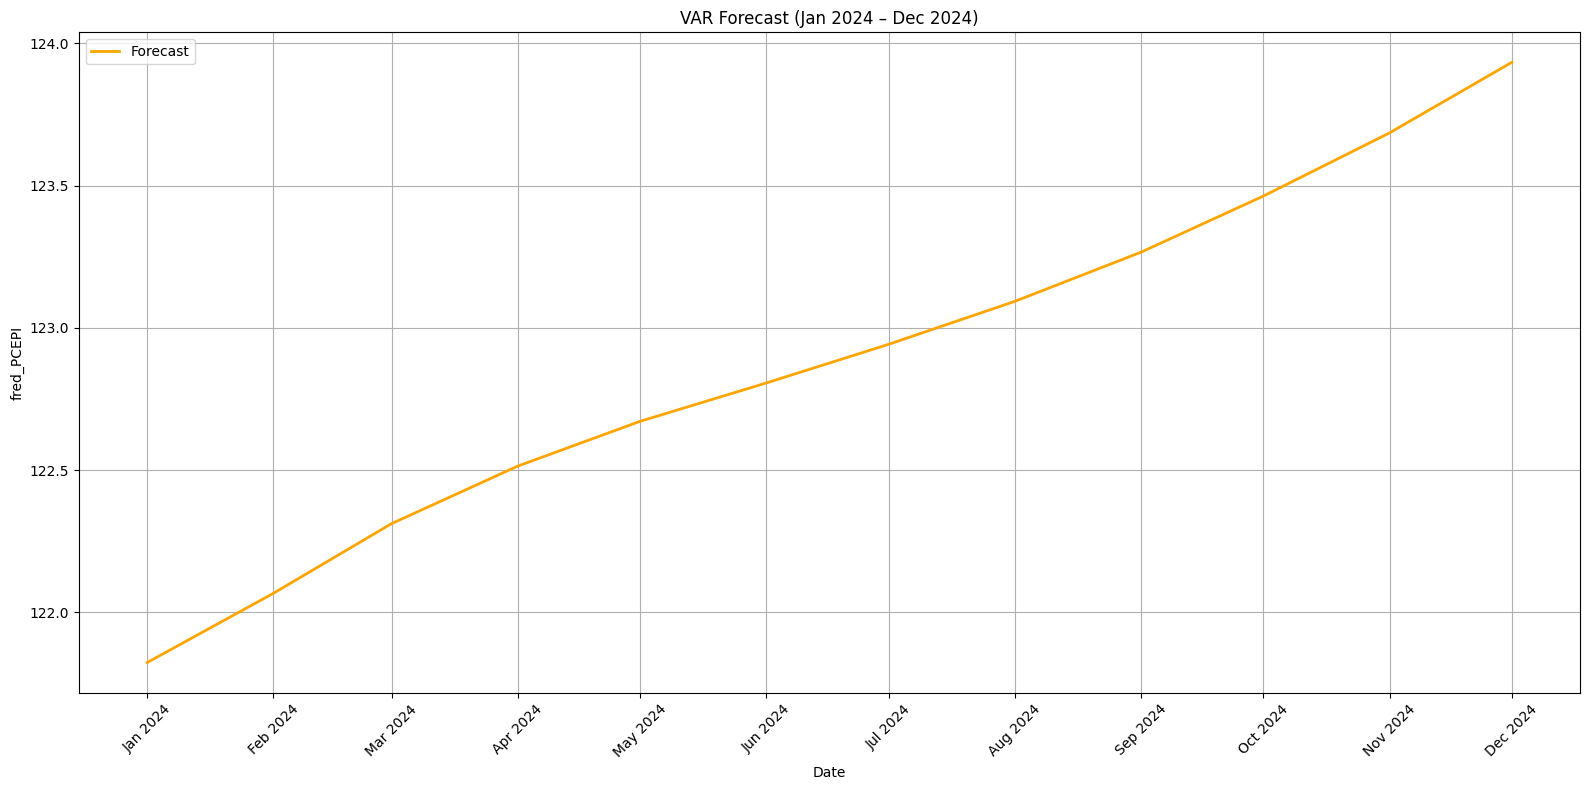

In [62]:
# Prediction for 2024
plt.figure(figsize=(16, 8))
plt.plot(best_forecast_df.index, best_forecast_df["Predicted"], label="Forecast", color="orange", linewidth=2)
plt.title("VAR Forecast (Jan 2024 – Dec 2024)")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
